# Identify Blood Cell Subtypes From Images
* Basophil vs Eosinophil vs Lymphocyte vs Monocyte vs Neutrophil
* Mononuclear (Basophil + Lymphocyte vs Monocyte) vs Polynuclear (Neutrophil + Eosinophil)

An important problem in blood diagnostics is classifying different types of blood cells.  Here we have 410 original images and 12,500 augmented images of blood cells paired with subtype labels (Basophil vs Eosinophil vs Lymphocyte vs Monocyte vs Neutrophil).  We want to automatically classify each image according to the subtype of cells within it.

For more information about blood cells and blood cell subtypes, see the following links:
https://www.ncbi.nlm.nih.gov/books/NBK2263/ and https://www.ncbi.nlm.nih.gov/books/NBK2263/box/A26/?report=objectonly

*Step One: Import Modules*

In [1]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Lambda, MaxPool2D, BatchNormalization
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import xml.etree.ElementTree as ET
import sklearn
import itertools
import cv2
import scipy
import os
import csv
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


*Step Two: Plot Data*

In [2]:
dict_characters = {1:'NEUTROPHIL',2:'EOSINOPHIL',3:'MONOCYTE',4:'LYMPHOCYTE'}
dict_characters2 = {0:'Mononuclear',1:'Polynuclear'}

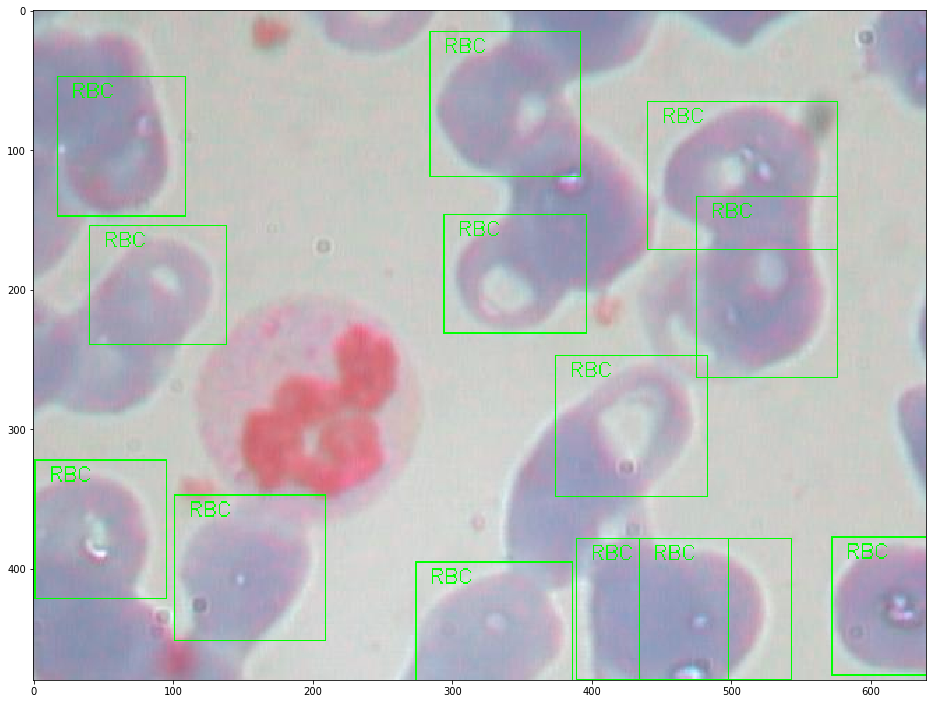

In [3]:
# Note that the function below is adapted from https://github.com/Shenggan/BCCD_Dataset
image = cv2.imread("../input/dataset-master/dataset-master/JPEGImages/BloodImage_00022.jpg")
tree = ET.parse("../input/dataset-master/dataset-master/Annotations/BloodImage_00022.xml")
for elem in tree.iter():
    if 'object' in elem.tag or 'part' in elem.tag:
        for attr in list(elem):
            if 'name' in attr.tag:
                name = attr.text
            if 'bndbox' in attr.tag:
                for dim in list(attr):
                    if 'xmin' in dim.tag:
                        xmin = int(round(float(dim.text)))
                    if 'ymin' in dim.tag:
                        ymin = int(round(float(dim.text)))
                    if 'xmax' in dim.tag:
                        xmax = int(round(float(dim.text)))
                    if 'ymax' in dim.tag:
                        ymax = int(round(float(dim.text)))
                if name[0] == "R":
                    cv2.rectangle(image, (xmin, ymin),
                                (xmax, ymax), (0, 255, 0), 1)
                    cv2.putText(image, name, (xmin + 10, ymin + 15),
                            cv2.FONT_HERSHEY_SIMPLEX, 1e-3 * image.shape[0], (0, 255, 0), 1)
                if name[0] == "W":
                    cv2.rectangle(image, (xmin, ymin),
                                (xmax, ymax), (0, 0, 255), 1)
                    cv2.putText(image, name, (xmin + 10, ymin + 15),
                            cv2.FONT_HERSHEY_SIMPLEX, 1e-3 * image.shape[0], (0, 0, 255), 1)
                if name[0] == "P":
                    cv2.rectangle(image, (xmin, ymin),
                                (xmax, ymax), (255, 0, 0), 1)
                    cv2.putText(image, name, (xmin + 10, ymin + 15),
                            cv2.FONT_HERSHEY_SIMPLEX, 1e-3 * image.shape[0], (255, 0, 0), 1)
plt.figure(figsize=(16,16))
plt.imshow(image)
plt.show()

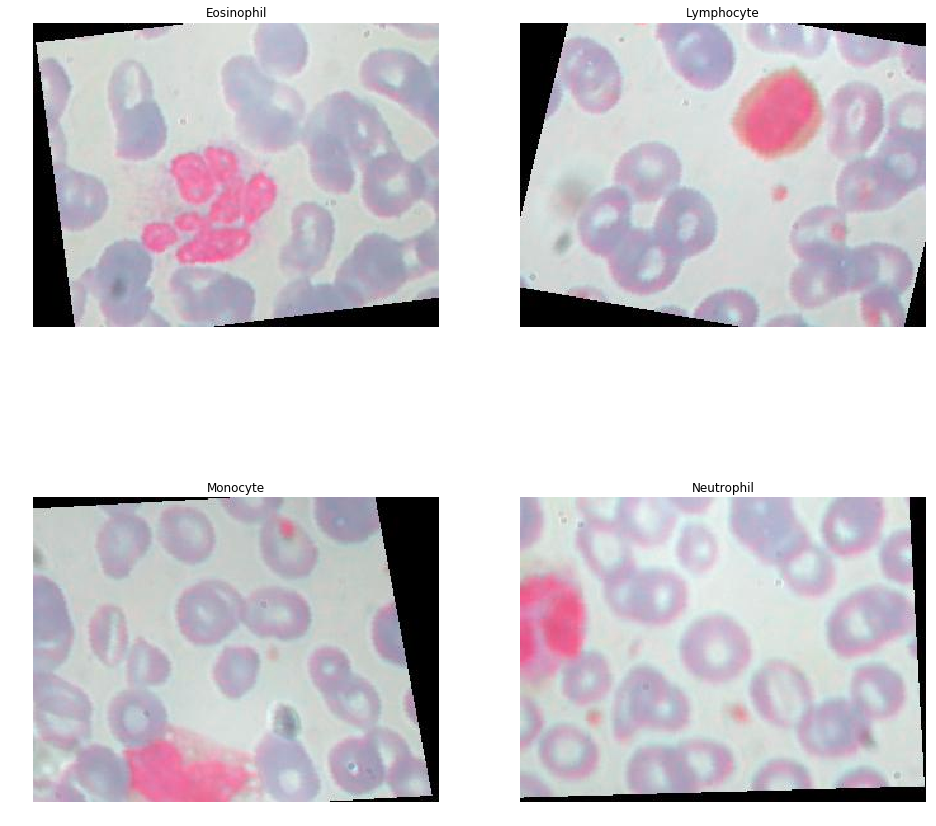

In [4]:
# Plot Image
def plotImage(image_location):
    image = cv2.imread(image_name)
    plt.imshow(image)
    return
image_name = '../input/dataset2-master/dataset2-master/images/TRAIN/EOSINOPHIL/_0_207.jpeg'
plt.figure(figsize=(16,16))
plt.subplot(221)
plt.title('Eosinophil')
plt.axis('off') 
plotImage(image_name)
image_name = '../input/dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_0_204.jpeg'
plt.subplot(222)
plt.title('Lymphocyte')
plt.axis('off') 
plotImage(image_name)
image_name = '../input/dataset2-master/dataset2-master/images/TRAIN/MONOCYTE/_0_180.jpeg'
plt.subplot(223)
plt.title('Monocyte')
plt.axis('off') 
plotImage(image_name)
plt.subplot(224)
image_name = '../input/dataset2-master/dataset2-master/images/TRAIN/NEUTROPHIL/_0_292.jpeg'
plt.title('Neutrophil')
plt.axis('off') 
plotImage(image_name)

*Step Three: Describe Data*

[  3  88  33  21 207]


Text(0,0.5,'Counts')

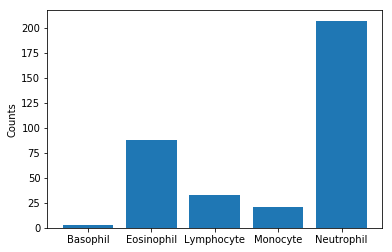

In [5]:
reader = csv.reader(open('../input/dataset2-master/dataset2-master/labels.csv'))
# skip the header
next(reader)
X3 = []
y3 = []
for row in reader:
    label = row[2]
    if len(label) > 0 and label.find(',') == -1:
        y3.append(label)
y3 = np.asarray(y3)
encoder = LabelEncoder()
encoder.fit(y3)
encoded_y = encoder.transform(y3)
counts = np.bincount(encoded_y)
print(counts)
fig, ax = plt.subplots()
plt.bar(list(range(5)), counts)
ax.set_xticklabels(('', 'Basophil', 'Eosinophil', 'Lymphocyte', 'Monocyte', 'Neutrophil'))
ax.set_ylabel('Counts')

Here you can see that with the original images we have imbalanced class sizes.  We will use the augmented images instead because they no longer have imbalanced class sizes due to oversampling.

*Step Four: Load Augmented Dataset*

In [6]:
from tqdm import tqdm
def get_data(folder):
    """
    Load the data and labels from the given folder.
    """
    X = []
    y = []
    z = []
    for wbc_type in os.listdir(folder):
        if not wbc_type.startswith('.'):
            if wbc_type in ['NEUTROPHIL']:
                label = 1
                label2 = 1
            elif wbc_type in ['EOSINOPHIL']:
                label = 2
                label2 = 1
            elif wbc_type in ['MONOCYTE']:
                label = 3  
                label2 = 0
            elif wbc_type in ['LYMPHOCYTE']:
                label = 4 
                label2 = 0
            else:
                label = 5
                label2 = 0
            for image_filename in tqdm(os.listdir(folder + wbc_type)):
                img_file = cv2.imread(folder + wbc_type + '/' + image_filename)
                if img_file is not None:
                    # Downsample the image to 120, 160, 3
                    img_file = scipy.misc.imresize(arr=img_file, size=(120, 160, 3))
                    img_arr = np.asarray(img_file)
                    X.append(img_arr)
                    y.append(label)
                    z.append(label2)
    X = np.asarray(X)
    y = np.asarray(y)
    z = np.asarray(z)
    return X,y,z
X_train, y_train, z_train = get_data('../input/dataset2-master/dataset2-master/images/TRAIN/')
X_test, y_test, z_test = get_data('../input/dataset2-master/dataset2-master/images/TEST/')

# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
from keras.utils.np_utils import to_categorical
y_trainHot = to_categorical(y_train, num_classes = 5)
y_testHot = to_categorical(y_test, num_classes = 5)
z_trainHot = to_categorical(z_train, num_classes = 2)
z_testHot = to_categorical(z_test, num_classes = 2)
print(dict_characters)
print(dict_characters2)

  0%|          | 0/2478 [00:00<?, ?it/s]/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:30: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
100%|██████████| 624/624 [00:01<00:00, 397.00it/s]

{1: 'NEUTROPHIL', 2: 'EOSINOPHIL', 3: 'MONOCYTE', 4: 'LYMPHOCYTE'}
{0: 'Mononuclear', 1: 'Polynuclear'}


*Step Five: Describe Augmented Dataset*

{1: 'NEUTROPHIL', 2: 'EOSINOPHIL', 3: 'MONOCYTE', 4: 'LYMPHOCYTE'}


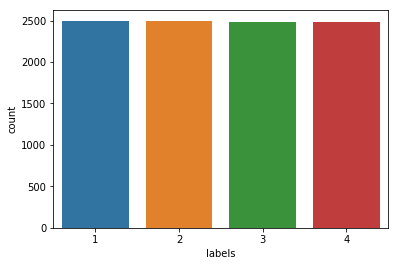

In [7]:
import seaborn as sns
df = pd.DataFrame()
df["labels"]=y_train
lab = df['labels']
dist = lab.value_counts()
sns.countplot(lab)
print(dict_characters)

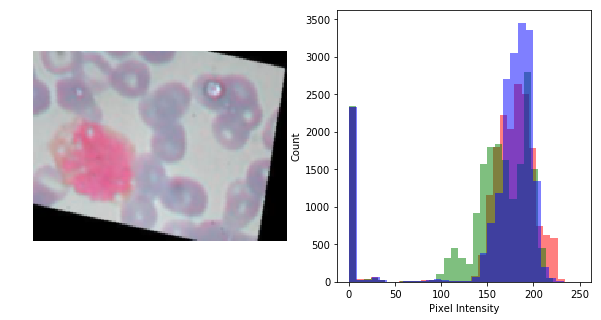

In [8]:
def plotHistogram(a):
    """
    Plot histogram of RGB Pixel Intensities
    """
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(a)
    plt.axis('off')
    histo = plt.subplot(1,2,2)
    histo.set_ylabel('Count')
    histo.set_xlabel('Pixel Intensity')
    n_bins = 30
    plt.hist(a[:,:,0].flatten(), bins= n_bins, lw = 0, color='r', alpha=0.5);
    plt.hist(a[:,:,1].flatten(), bins= n_bins, lw = 0, color='g', alpha=0.5);
    plt.hist(a[:,:,2].flatten(), bins= n_bins, lw = 0, color='b', alpha=0.5);
plotHistogram(X_train[1])

*Step Six: Preprocess Data*

In [9]:
X_train=np.array(X_train)
X_train=X_train/255.0

X_test=np.array(X_test)
X_test=X_test/255.0

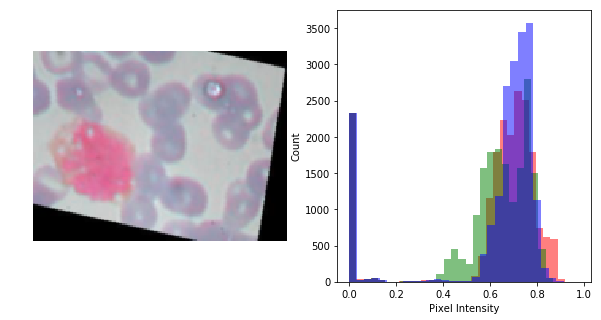

In [10]:
plotHistogram(X_train[1])

*Step Seven: Define Helper Functions*

In [11]:
# Helper Functions  Learning Curves and Confusion Matrix

from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

class MetricsCheckpoint(Callback):
    """Callback that saves metrics after each epoch"""
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

def plotKerasLearningCurve():
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy')[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('Number of epochs')
    plt.ylabel('Accuracy')

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot_learning_curve(history):
    plt.figure(figsize=(8,8))
    plt.subplot(1,2,1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./accuracy_curve.png')
    #plt.clf()
    # summarize history for loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./loss_curve.png')

*Step Eight: Evaluate Classification Models*

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 120, 160, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 118, 158, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 118, 158, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 59, 79, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 57, 77, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 57, 77, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 38, 32)        0         
__________

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



             precision    recall  f1-score   support

 NEUTROPHIL       0.00      0.00      0.00       624
 EOSINOPHIL       0.00      0.00      0.00       623
   MONOCYTE       0.00      0.00      0.00       620
 LYMPHOCYTE       0.25      1.00      0.40       620

avg / total       0.06      0.25      0.10      2487



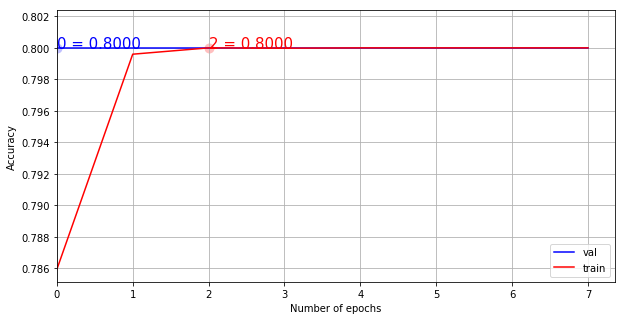

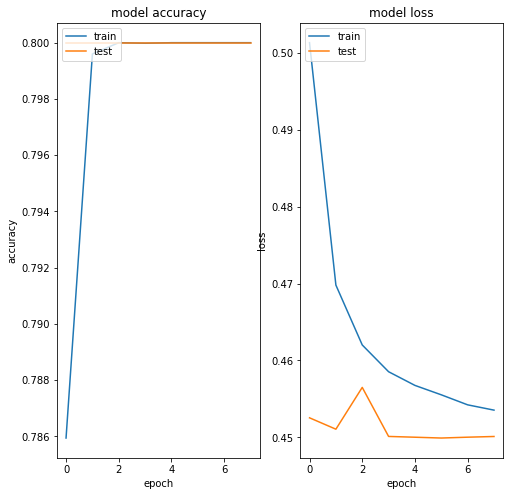

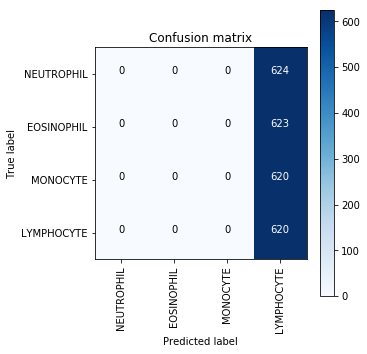

In [12]:
dict_characters = {1:'NEUTROPHIL',2:'EOSINOPHIL',3:'MONOCYTE',4:'LYMPHOCYTE'}
dict_characters2 = {0:'Mononuclear',1:'Polynuclear'}
def bloodnetwork(a,b,c,d):
    num_classes = len(b[0])
    epochs = 8
    batch_size = 32
    model = Sequential()
    model.add(Lambda(lambda x: x * 1./255., input_shape=(120, 160, 3), output_shape=(120, 160, 3)))
    model.add(Conv2D(32, (3, 3), input_shape=(120, 160, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.7))
    model.add(Dense(num_classes))
    model.add(Activation('sigmoid'))

    model.compile(loss='binary_crossentropy',
                optimizer='rmsprop',
                metrics=['accuracy'])
    print(model.summary())
    history = model.fit(a,b,
    validation_split=0.2,
    epochs=epochs,
    shuffle=True,
    batch_size=batch_size,
    validation_data = [c, d],callbacks = [MetricsCheckpoint('logs')])
    #model.save_weights('model1.h5')
    score = model.evaluate(c,d, verbose=0) 
    print('\nKeras CNN - accuracy:', score[1],'\n')
    Y_pred = model.predict(c)
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(Y_pred, axis=1), target_names=list(dict_characters.values())), sep='')    
    Y_pred_classes = np.argmax(Y_pred,axis = 1) 
    Y_true = np.argmax(d,axis = 1)
    plotKerasLearningCurve()
    plt.show()  
    plot_learning_curve(history)
    plt.show()
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix(confusion_mtx, classes = list(dict_characters.values())) 
    plt.show()
bloodnetwork(X_train,y_trainHot,X_test,y_testHot)

This model is unsatisfactory due to high bias.  Perhaps it will work better for a binary classification task, such as determining whether the cell is polynuclear (e.g. neutrophil and eusinophil) or mononuclear (e.g. every other subtype).  

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_2 (Lambda)            (None, 120, 160, 3)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 118, 158, 32)      896       
_________________________________________________________________
activation_6 (Activation)    (None, 118, 158, 32)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 59, 79, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 57, 77, 32)        9248      
_________________________________________________________________
activation_7 (Activation)    (None, 57, 77, 32)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 28, 38, 32)        0         
__________

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



             precision    recall  f1-score   support

Mononuclear       0.00      0.00      0.00      1240
Polynuclear       0.50      1.00      0.67      1247

avg / total       0.25      0.50      0.33      2487



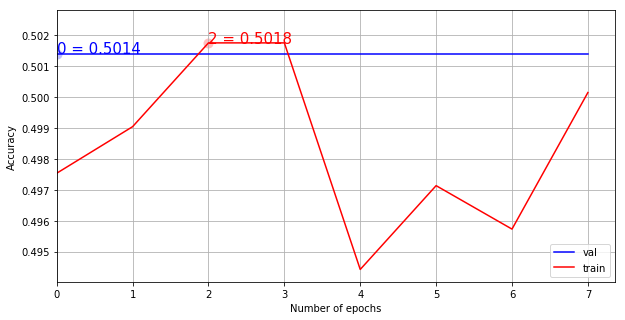

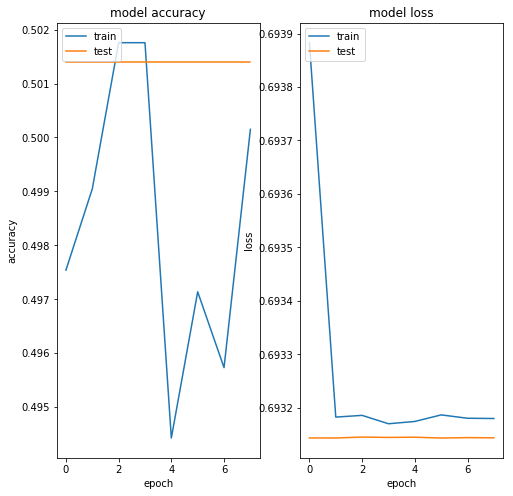

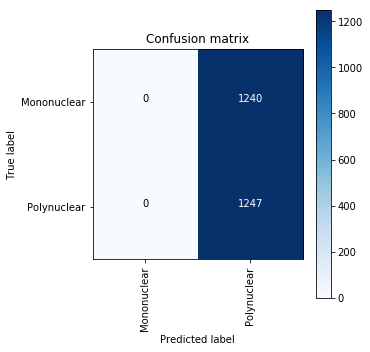

In [13]:
dict_characters = dict_characters2
bloodnetwork(X_train,z_trainHot,X_test,z_testHot)   
dict_characters = {1:'NEUTROPHIL',2:'EOSINOPHIL',3:'MONOCYTE',4:'LYMPHOCYTE'}
dict_characters2 = {0:'Mononuclear',1:'Polynuclear'}

Once again the model is unsatisfactory due to high bias.  Perhaps a different NN architecture and some additional data augmentation will help.

Epoch 1/8
312/311 [==============================] - 1042s 3s/step - loss: 1.5020 - acc: 0.2840 - val_loss: 1.2412 - val_acc: 0.4375
Epoch 2/8
312/311 [==============================] - 1017s 3s/step - loss: 1.2964 - acc: 0.3903 - val_loss: 1.1772 - val_acc: 0.4636
Epoch 3/8
312/311 [==============================] - 984s 3s/step - loss: 1.1708 - acc: 0.4636 - val_loss: 0.9774 - val_acc: 0.5384
Epoch 4/8
312/311 [==============================] - 1061s 3s/step - loss: 1.0520 - acc: 0.5267 - val_loss: 1.0920 - val_acc: 0.4515
Epoch 5/8
312/311 [==============================] - 1088s 3s/step - loss: 0.9488 - acc: 0.5776 - val_loss: 0.7471 - val_acc: 0.6538
Epoch 6/8
312/311 [==============================] - 1009s 3s/step - loss: 0.8382 - acc: 0.6213 - val_loss: 0.6900 - val_acc: 0.6908
Epoch 7/8
312/311 [==============================] - 1020s 3s/step - loss: 0.7332 - acc: 0.6642 - val_loss: 0.6971 - val_acc: 0.6767
Epoch 8/8
312/311 [==============================] - 1055s 3s/step - l

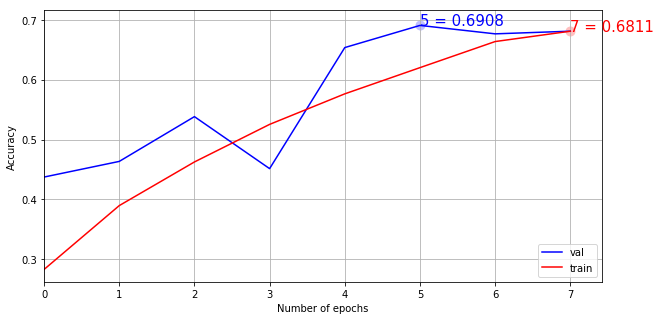

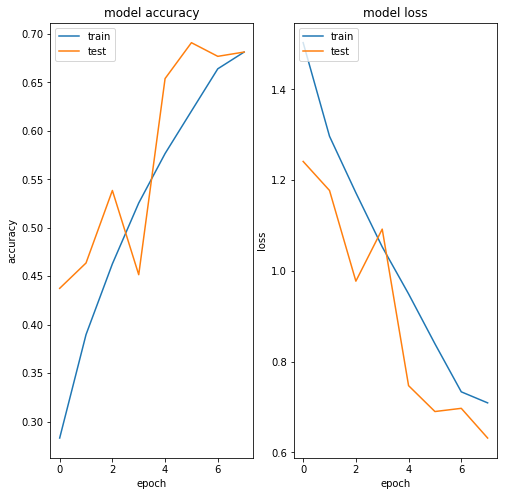

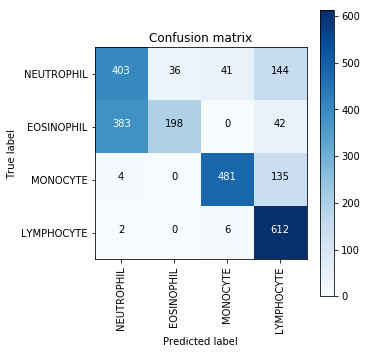

In [14]:
import keras
def runKerasCNNAugment(a,b,c,d):
    batch_size = 128
    num_classes = len(b[0])
    epochs = 8
#     img_rows, img_cols = a.shape[1],a.shape[2]
    img_rows,img_cols=120,160
    input_shape = (img_rows, img_cols, 3)
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images
    history = model.fit_generator(datagen.flow(a,b, batch_size=32),
                        steps_per_epoch=len(a) / 32, epochs=epochs, validation_data = [c, d],callbacks = [MetricsCheckpoint('logs')])
    score = model.evaluate(c,d, verbose=0)
    print('\nKeras CNN #1C - accuracy:', score[1],'\n')
    y_pred = model.predict(c)
    map_characters = dict_characters
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')    
    Y_pred_classes = np.argmax(y_pred,axis=1) 
    Y_true = np.argmax(d,axis=1)
    plotKerasLearningCurve()
    plt.show()  
    plot_learning_curve(history)
    plt.show()
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix(confusion_mtx, classes = list(dict_characters.values())) 
    plt.show()
runKerasCNNAugment(X_train,y_trainHot,X_test,y_testHot)

Here we are finally seeing some improvement.  70% accuracy is much better than random chance!  Perhaps this model will work better for a binary classification task, such as determining whether the cell is polynuclear (e.g. neutrophil and eusinophil) or mononuclear (e.g. every other subtype).  

Epoch 1/8
312/311 [==============================] - 1037s 3s/step - loss: 0.8093 - acc: 0.4981 - val_loss: 0.6932 - val_acc: 0.4998
Epoch 2/8
312/311 [==============================] - 975s 3s/step - loss: 0.6944 - acc: 0.5238 - val_loss: 0.6880 - val_acc: 0.5026
Epoch 3/8
312/311 [==============================] - 1012s 3s/step - loss: 0.6834 - acc: 0.5718 - val_loss: 0.6455 - val_acc: 0.7021
Epoch 4/8
312/311 [==============================] - 1040s 3s/step - loss: 0.6591 - acc: 0.5997 - val_loss: 0.5771 - val_acc: 0.7097
Epoch 5/8
312/311 [==============================] - 1000s 3s/step - loss: 0.6075 - acc: 0.6660 - val_loss: 0.5374 - val_acc: 0.7350
Epoch 6/8
312/311 [==============================] - 1021s 3s/step - loss: 0.5401 - acc: 0.7363 - val_loss: 0.6565 - val_acc: 0.6297
Epoch 7/8
312/311 [==============================] - 1056s 3s/step - loss: 0.4984 - acc: 0.7574 - val_loss: 0.5038 - val_acc: 0.7378
Epoch 8/8
312/311 [==============================] - 1023s 3s/step - l

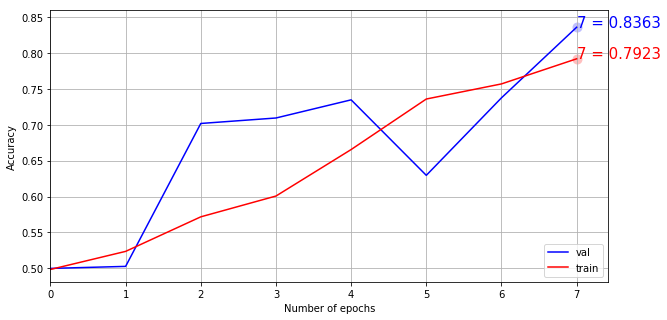

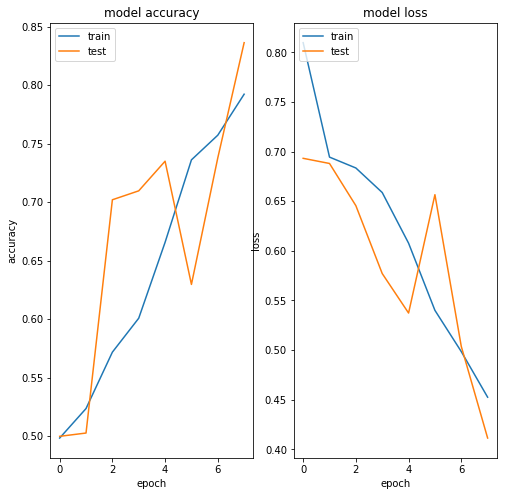

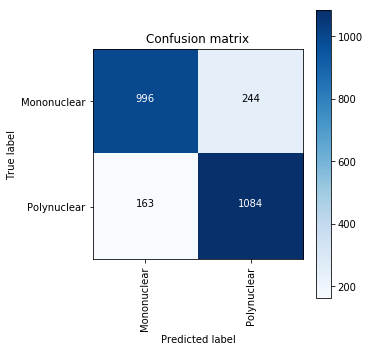

In [15]:
dict_characters = dict_characters2
runKerasCNNAugment(X_train,z_trainHot,X_test,z_testHot)   
dict_characters = {1:'NEUTROPHIL',2:'EOSINOPHIL',3:'MONOCYTE',4:'LYMPHOCYTE'}
dict_characters2 = {0:'Mononuclear',1:'Polynuclear'}

That worked reasonably well, with 80% accuracy for two categories {1:'MONONUCLEAR',2:'POLYNUCLEAR'} as compared to 70% accuracy for four categories {1:'NEUTROPHIL',2:'EOSINOPHIL',3:'MONOCYTE',4:'LYMPHOCYTE'}.  

I will try again later to improve the performance of this model for determining which subtype of cell is present within each image, perhaps by using transfer learning.

Experiment Below: